# 4. Further analysis of trends in ERIC data

Continue the analysis, looking at trends over time, and particularly trusts that have increased or decreased their spending notably.

*Summary of findings*

- Of currently active trusts: 73 active trusts have successfully cut spending over the period, but 118 trusts have increased their spending over the period
- Only one active acute trust is spending nothing on medical records (Buckingham) - we will have to check if this is accurate or a data quality issue.


In [1]:
import os
import random

import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.ticker import StrMethodFormatter

Import combined data.

In [2]:
df = pd.read_csv("./data/output/trust_mrc_and_epr.csv")
df.head()

,trust_code,trust_name,mrc_off_201718,mrc_off_201819,mrc_off_201920,mrc_off_202021,mrc_off_202122,mrc_off_202223,mrc_off_202324,mrc_on_201718,...,mrc_total_202122,mrc_total_202223,mrc_total_202324,current_name_in_foi,trust_type_from_foi,trust_epr,in_foi_data,all_admissions_22,emergency_admissions_22,mrc_total_202324_perpatient
0,RTQ,"2GETHER NHS FOUNDATION TRUST, GLOUCESTERSHIRE ...",34648.0,39826.0,39031.0,111500.0,111500.0,42500.0,64799.0,0.0,...,632233.0,588488.0,612164.0,GLOUCESTERSHIRE HEALTH AND CARE NHS FOUNDATION...,Mental Health and Community (Combined),TPP,True,NaN,NaN,NaN
1,REM,AINTREE UNIVERSITY HOSPITAL NHS FOUNDATION TRU...,65590.0,56657.0,58981.0,101922.0,1646581.0,1534829.0,1120134.0,69250.0,...,3293162.0,1679579.0,1120134.0,LIVERPOOL UNIVERSITY HOSPITALS NHS FOUNDATION ...,Acute,Dedalus Healthcare Ltd,True,705871.0,700130.0,1.59
2,RCF,AIREDALE NHS FOUNDATION TRUST,0.0,0.0,0.0,0.0,0.0,0.0,0.0,498051.0,...,554805.0,577884.0,715884.0,AIREDALE NHS FOUNDATION TRUST,Acute,TPP,True,188607.0,195373.0,3.80
3,RBS,ALDER HEY CHILDRENS NHS FOUNDATION TRUST,0.0,70.0,70.0,70.0,187744.0,548176.0,95580.0,71500.0,...,593662.0,977059.0,534275.0,ALDER HEY CHILDREN'S NHS FOUNDATION TRUST,Acute,Meditech Group Limited,True,NaN,NaN,NaN
4,RTK,ASHFORD AND ST. PETER'S HOSPITALS NHS FOUNDATI...,53010.0,53010.0,78692.0,92854.0,77554.0,172013.0,74413.0,1001766.0,...,900181.0,976980.0,764964.0,ASHFORD AND ST PETER'S HOSPITALS NHS FOUNDATIO...,Acute,Oracle Cerner Corporation,True,351397.0,351397.0,2.18


In [12]:
YEARS = [x.split('_')[-1] for x in [col for col in df.columns if col.startswith('mrc_on')]]

## Visualise total on/offsite spending, and check for outliers

Visualise on-site and off-site spending for 2023/24. This also helps us see the outliers.

There's a weak positive correlation of about 0.3 between on and offsite spending. 

In [6]:
df.trust_type_from_foi.value_counts()
type_codes = {
    "Acute": 0, "Mental Health and Community (Combined)": 1, "Mental Health": 2, "Community": 3, "Ambulance": 4
}
df['trust_type_code'] = df.trust_type_from_foi.map(type_codes)

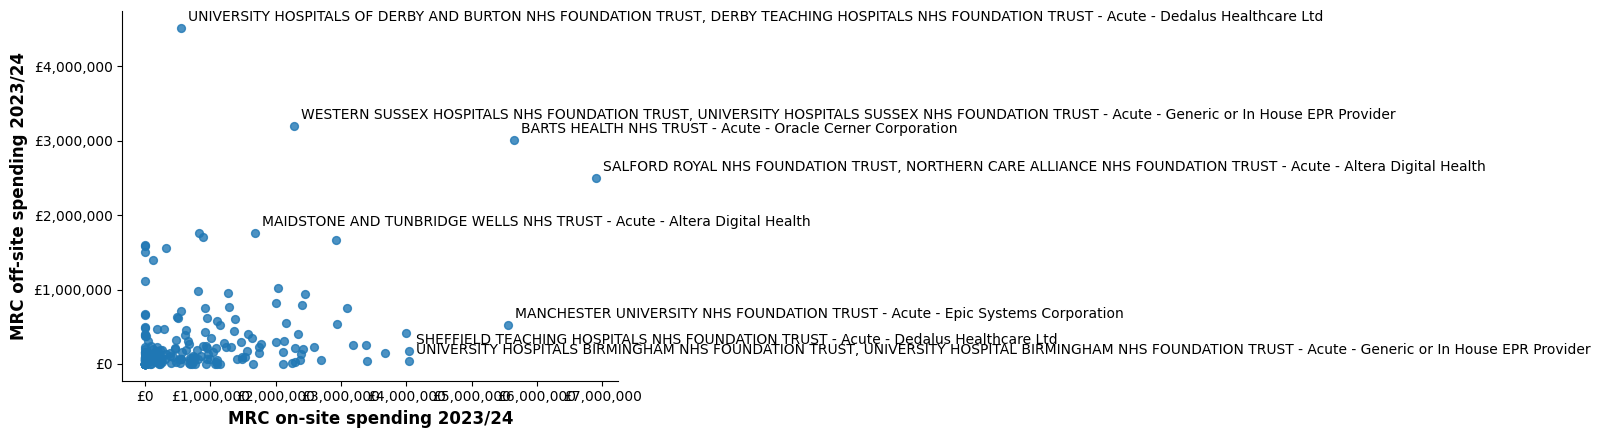

In [5]:
scatter = df.plot(kind='scatter', 
                 x='mrc_on_202324', 
                 y='mrc_off_202324', 
                 s=32, 
                 alpha=.8)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('£{x:,.0f}'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('£{x:,.0f}'))

# Label the outliers.
x_threshold = df['mrc_on_202324'].quantile(0.98)
y_threshold = df['mrc_off_202324'].quantile(0.98)
for idx, row in df.iterrows():
    if (row['mrc_on_202324'] > x_threshold) or (row['mrc_off_202324'] > y_threshold):
        plt.annotate(row['trust_name'] + ' - ' + row.trust_type_from_foi + ' - ' + row.trust_epr,
                    (row['mrc_on_202324'], row['mrc_off_202324']),
                    xytext=(5, 5), 
                    textcoords='offset points')
plt.xlabel('MRC on-site spending 2023/24', fontsize=12, fontweight='bold')
plt.ylabel('MRC off-site spending 2023/24', fontsize=12, fontweight='bold')
plt.show()

In [73]:
pearson_corr = df['mrc_on_202324'].corr(df['mrc_off_202324'])
print(f"Correlation between on and offsite spending: {pearson_corr:.3f}")

Correlation between on and offsite spending: 0.349


## Find the trusts that genuinely spend nothing on medical records storage 🥇

There are now 16 of these - but only one is an acute trust, they are mostly ambulance trusts.

So only one active acute trust appears to spend nothing on medical records - Buckingham. Of course, it's possible this is a data entry issue.

In [9]:
df_both_equal_0 = df[(df.mrc_on_202324 == 0) & (df.mrc_off_202324 == 0) & df.in_foi_data]
df_both_equal_0[['trust_name', 'trust_code', 'trust_type_from_foi', 'trust_epr']].sort_values(by="trust_type_from_foi")

,trust_name,trust_code,trust_type_from_foi,trust_epr
23,BUCKINGHAMSHIRE HEALTHCARE NHS TRUST,RXQ,Acute,System C Healthcare Ltd
56,EAST MIDLANDS AMBULANCE SERVICE NHS TRUST,RX9,Ambulance,Medusa Medical Technologies Inc
57,EAST OF ENGLAND AMBULANCE SERVICE NHS TRUST,RYC,Ambulance,Medusa Medical Technologies Inc
100,LONDON AMBULANCE SERVICE NHS TRUST,RRU,Ambulance,Cleric Computer Services Ltd
117,NORTH EAST AMBULANCE SERVICE NHS FOUNDATION TRUST,RX6,Ambulance,Cleric Computer Services Ltd
122,NORTH WEST AMBULANCE SERVICE NHS TRUST,RX7,Ambulance,Dedalus Healthcare Ltd
165,SOUTH CENTRAL AMBULANCE SERVICE NHS FOUNDATION...,RYE,Ambulance,Ortivus UK Ltd
166,SOUTH EAST COAST AMBULANCE SERVICE NHS FOUNDAT...,RYD,Ambulance,Cleric Computer Services Ltd
174,SOUTH WESTERN AMBULANCE SERVICE NHS FOUNDATION...,RYF,Ambulance,Ortivus UK Ltd
220,WEST MIDLANDS AMBULANCE SERVICE NHS FOUNDATION...,RYA,Ambulance,Cleric Computer Services Ltd


## Examine the top current spenders

Trusts with the highest spending in the most recent year (as per previous notebook).

In [26]:
current_year = YEARS[-1]
mrc_on_col = f'mrc_on_{current_year}'
mrc_off_col = f'mrc_off_{current_year}'
df['total_mrc_current'] = df[mrc_on_col] + df[mrc_off_col]
top_spenders = df.sort_values('total_mrc_current', ascending=False).head(10)
print(top_spenders[['trust_name', 'total_mrc_current']])

                                            trust_name  total_mrc_current
154  SALFORD ROYAL NHS FOUNDATION TRUST, NORTHERN C...          9396882.0
9                               BARTS HEALTH NHS TRUST          8665318.0
104         MANCHESTER UNIVERSITY NHS FOUNDATION TRUST          6081336.0
222  WESTERN SUSSEX HOSPITALS NHS FOUNDATION TRUST,...          5480595.0
211  UNIVERSITY HOSPITALS OF DERBY AND BURTON NHS F...          5074281.0
87        KING'S COLLEGE HOSPITAL NHS FOUNDATION TRUST          4591272.0
175  SOUTHEND UNIVERSITY HOSPITAL NHS FOUNDATION TR...          4420479.0
159  SHEFFIELD TEACHING HOSPITALS NHS FOUNDATION TRUST          4210874.0
207  UNIVERSITY HOSPITALS BIRMINGHAM NHS FOUNDATION...          4081450.0
53   EAST KENT HOSPITALS UNIVERSITY NHS FOUNDATION ...          3857212.0


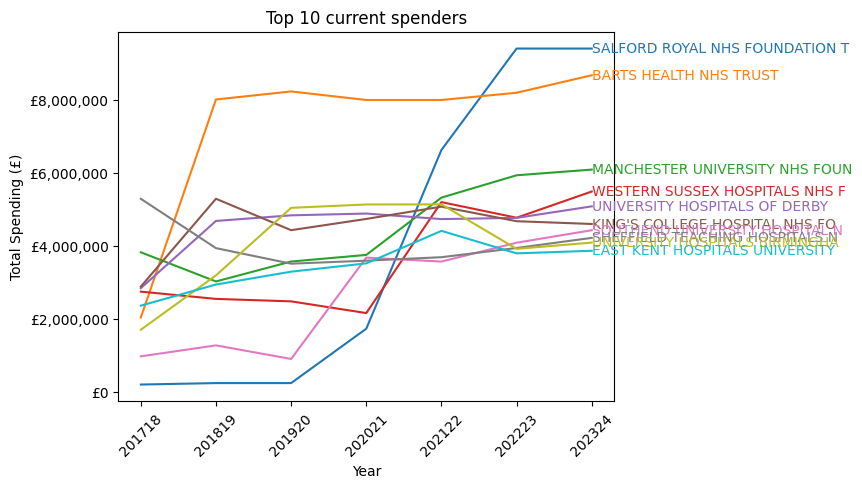

In [27]:
# @title Chart of top current spenders
for trust_code in top_spenders.index:
    trust_name = df.loc[trust_code, 'trust_name']
    trust_data = []
    for year in YEARS:
        trust_data.append(df.loc[trust_code, f'mrc_on_{year}'] + df.loc[trust_code, f'mrc_off_{year}'])
    line, = plt.plot(YEARS, trust_data, label=trust_name)
    plt.text(YEARS[-1], trust_data[-1], trust_name[:30], ha='left', va='center', color=line.get_color())

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('£{x:,.0f}'))
plt.xlabel("Year")
plt.ylabel("Total Spending (£)")
plt.title("Top 10 current spenders")
plt.xticks(rotation=45)
plt.show()

In [28]:
df[df.trust_name == "SHEFFIELD CHILDRENS NHS FOUNDATION TRUST"]

,trust_code,trust_name,mrc_off_201718,mrc_off_201819,mrc_off_201920,mrc_off_202021,mrc_off_202122,mrc_off_202223,mrc_off_202324,mrc_on_201718,...,in_foi_data,all_admissions_22,emergency_admissions_22,mrc_total_202324_perpatient,trust_type_code,total_mrc_current,total_mrc_start,total_mrc_end,absolute_reduction,absolute_gain
157,RCU,SHEFFIELD CHILDRENS NHS FOUNDATION TRUST,0.0,0.0,46474.0,38431.0,44061.0,36216.0,4221.0,55688000.0,...,True,NaN,NaN,NaN,0.0,767948.0,55688000.0,767948.0,54920052.0,-54920052.0


## Examine the trusts with the biggest reductions in spending over the period

Find the active trusts with the biggest falls in spending between 2017/18 and the current year.

These trusts could be explored as examples of good practice. (I suppose it's also possible they might have subdivided and therefore be spending less, though this seems unlikely.)

NB - Sheffield is a massive outlier, this is because the file for 2017/18 says it spent £55.7m on medical records, whcih I assume is a typo! We exclude it from our analyses.

In [29]:
df['total_mrc_start'] = df[f'mrc_on_{YEARS[0]}'] + df[f'mrc_off_{YEARS[0]}']
df['total_mrc_end'] = df[f'mrc_on_{YEARS[-1]}'] + df[f'mrc_off_{YEARS[-1]}']
df['absolute_reduction'] = df['total_mrc_start'] - df['total_mrc_end']
biggest_reductions = df[df.in_foi_data].sort_values('absolute_reduction', ascending=False).head(10)
print(biggest_reductions[['trust_name', 'total_mrc_start', 'total_mrc_end', 'absolute_reduction']])

                                            trust_name  total_mrc_start  \
157           SHEFFIELD CHILDRENS NHS FOUNDATION TRUST       55688000.0   
62                 FRIMLEY HEALTH NHS FOUNDATION TRUST        3705747.0   
156   SANDWELL AND WEST BIRMINGHAM HOSPITALS NHS TRUST        3507080.0   
80               IMPERIAL COLLEGE HEALTHCARE NHS TRUST        3881000.0   
143               ROYAL BERKSHIRE NHS FOUNDATION TRUST        2702236.0   
204  UNIVERSITY COLLEGE LONDON NHS FOUNDATION TRUST...        3849996.0   
23                BUCKINGHAMSHIRE HEALTHCARE NHS TRUST        1495869.0   
72         HARROGATE AND DISTRICT NHS FOUNDATION TRUST        1669180.0   
32   CHELSEA AND WESTMINSTER HOSPITAL NHS FOUNDATIO...        2797337.0   
159  SHEFFIELD TEACHING HOSPITALS NHS FOUNDATION TRUST        5280929.0   

     total_mrc_end  absolute_reduction  
157       767948.0          54920052.0  
62        362413.0           3343334.0  
156       763454.0           2743626.0  
80       1

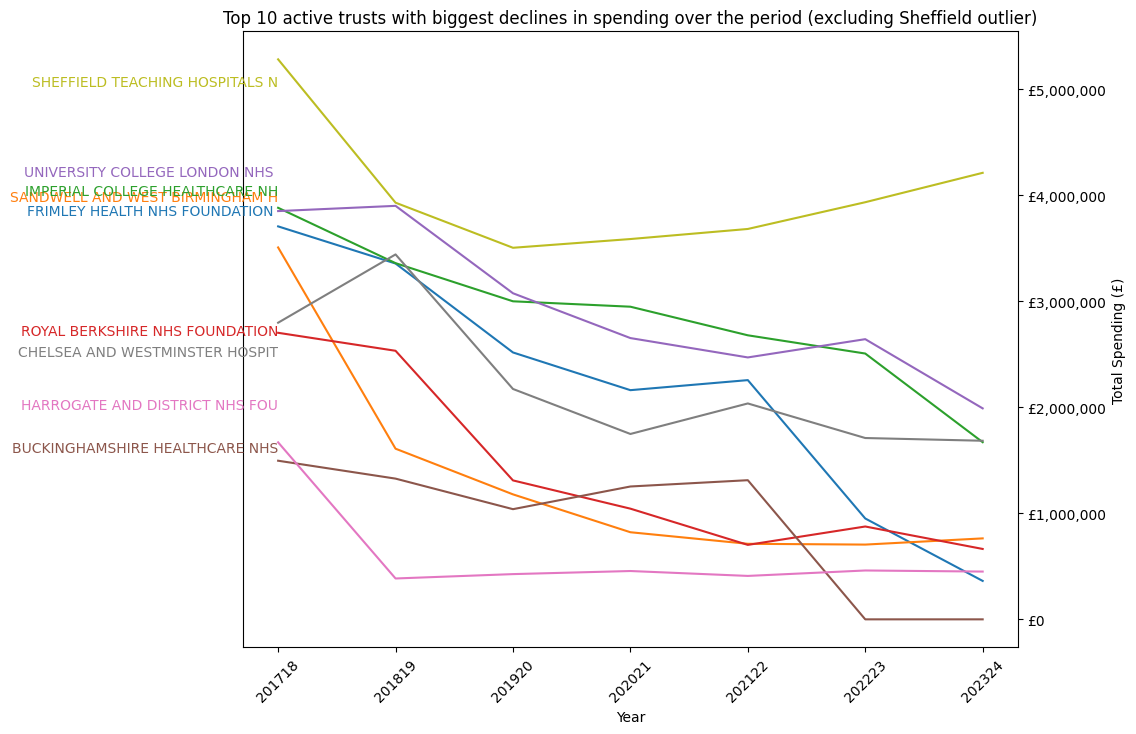

In [30]:
plt.figure(figsize=(10, 8))

for trust_code in biggest_reductions[biggest_reductions.in_foi_data][1:].index: 
    trust_name = df.loc[trust_code, 'trust_name']
    trust_data = []
    for year in YEARS:
        trust_data.append(df.loc[trust_code, f'mrc_on_{year}'] + df.loc[trust_code, f'mrc_off_{year}'])
    line, = plt.plot(YEARS, trust_data, label=trust_name)
    x_pos = YEARS[0]
    y_pos = trust_data[0] + random.uniform(-500000, 500000)
    plt.text(x_pos, y_pos, trust_name[:30], ha='right', va='center', color=line.get_color())

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('£{x:,.0f}'))
plt.xlabel("Year")
plt.ylabel("Total Spending (£)")
plt.title("Top 10 active trusts with biggest declines in spending over the period (excluding Sheffield outlier)")
plt.xticks(rotation=45)
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
plt.show()

In [31]:
print(len(df[df.in_foi_data & df.total_mrc_start]), 'trusts are both active now, and were spending on medical records in 2017/18. Of these:')
print(len(df[df.in_foi_data & df.total_mrc_start & (df.absolute_reduction > 0)]), 'trusts have successfully cut spending over the period')
print(len(df[df.in_foi_data & df.total_mrc_start & (df.absolute_reduction < 0)]), 'trusts have increased their spending over the period')

191 trusts are both active now, and were spending on medical records in 2017/18. Of these:
73 trusts have successfully cut spending over the period
118 trusts have increased their spending over the period


## Examine the trusts with the biggest gains in spending over the period

Conversely, look at the biggest gainers. Note that this needs further checking, because some of these trusts may have merged with others over the period.

NB we do exclude trusts with no spending in 2017/18 from this, on the assumption they simply didn't exist back then. Again if we had 

In [32]:
df['absolute_gain'] = df['absolute_reduction'] * -1
biggest_gains = df[df.in_foi_data & df.total_mrc_start].sort_values('absolute_gain', ascending=False).head(10)
print(biggest_gains[['trust_name', 'total_mrc_start', 'total_mrc_end', 'absolute_gain']])

                                            trust_name  total_mrc_start  \
154  SALFORD ROYAL NHS FOUNDATION TRUST, NORTHERN C...         193179.0   
9                               BARTS HEALTH NHS TRUST        2031200.0   
175  SOUTHEND UNIVERSITY HOSPITAL NHS FOUNDATION TR...         965328.0   
208  UNIVERSITY HOSPITALS BRISTOL NHS FOUNDATION TR...         445102.0   
51              EAST AND NORTH HERTFORDSHIRE NHS TRUST         798679.0   
222  WESTERN SUSSEX HOSPITALS NHS FOUNDATION TRUST,...        2738018.0   
214  UNIVERSITY HOSPITALS PLYMOUTH NHS TRUST, PLYMO...        1110228.0   
207  UNIVERSITY HOSPITALS BIRMINGHAM NHS FOUNDATION...        1694633.0   
104         MANCHESTER UNIVERSITY NHS FOUNDATION TRUST        3815942.0   
18                         BOLTON NHS FOUNDATION TRUST         243377.0   

     total_mrc_end  absolute_gain  
154      9396882.0      9203703.0  
9        8665318.0      6634118.0  
175      4420479.0      3455151.0  
208      3433734.0      298863

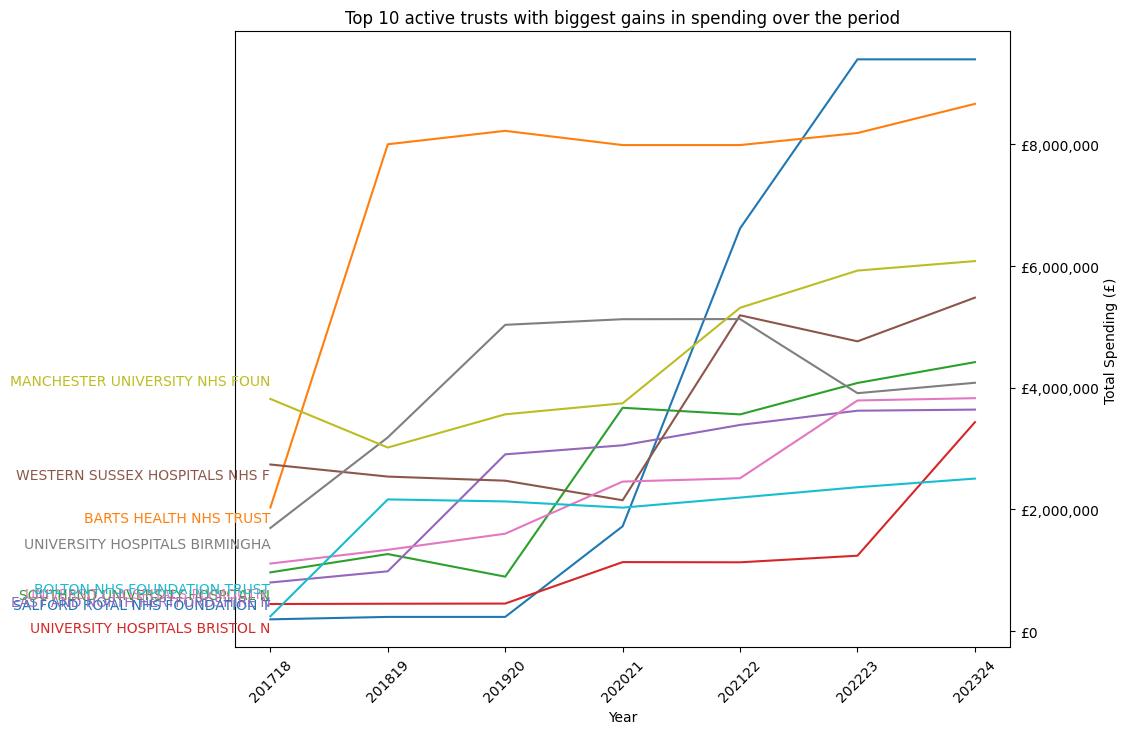

In [33]:
plt.figure(figsize=(10, 8))

for trust_code in biggest_gains.index: 
    trust_name = df.loc[trust_code, 'trust_name']
    trust_data = []
    for year in YEARS:
        trust_data.append(df.loc[trust_code, f'mrc_on_{year}'] + df.loc[trust_code, f'mrc_off_{year}'])
    line, = plt.plot(YEARS, trust_data, label=trust_name)
    x_pos = YEARS[0]
    y_pos = trust_data[0] + random.uniform(-500000, 500000)
    plt.text(x_pos, y_pos, trust_name[:30], ha='right', va='center', color=line.get_color())

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('£{x:,.0f}'))
plt.xlabel("Year")
plt.ylabel("Total Spending (£)")
plt.title("Top 10 active trusts with biggest gains in spending over the period")
plt.xticks(rotation=45)
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
plt.show()

# Examine how many trusts are spending on medical records storage

Slightly fewer trusts are spending on records overall.

CAUTION - this may just be because trusts have closed or merged. It's hard to know without reliable historic data on trust status, and ODS is difficult to use for this. Do not use this analysis until we have more reliable info about historic trust status.

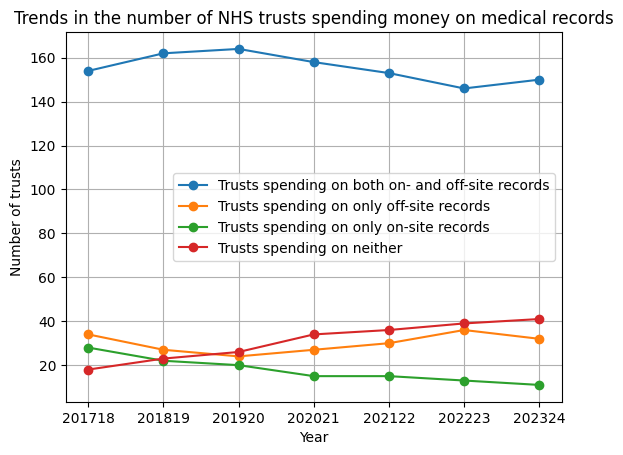

In [34]:
table_data = {}
for year in YEARS:
    mrc_on_col = f'mrc_on_{year}'
    mrc_off_col = f'mrc_off_{year}'
    df_both_above_0 = df[(df[mrc_on_col] > 0) & (df[mrc_off_col] > 0)]
    df_both_equal_0 = df[(df[mrc_on_col] == 0) & (df[mrc_off_col] == 0)]
    df_on_only = df[(df[mrc_on_col] > 0) & (df[mrc_off_col] == 0)]
    df_off_only = df[(df[mrc_on_col] == 0) & (df[mrc_off_col] > 0)]
    table_data[year] = {
        'Trusts spending on both on- and off-site records': len(df_both_above_0),
        'Trusts spending on only off-site records': len(df_off_only),
        'Trusts spending on only on-site records': len(df_on_only),
        'Trusts spending on neither': len(df_both_equal_0),
    }
table_df = pd.DataFrame.from_dict(table_data, orient='index')
# print(table_df.keys())
table_df.plot(kind='line', marker='o')
plt.title('Trends in the number of NHS trusts spending money on medical records')
plt.xlabel('Year')
plt.ylabel('Number of trusts')
plt.legend(loc='best')
plt.grid(True)
plt.show()